In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
import supervision as sv
import os

In [3]:
def pixel_accuracy(pred, target):
    correct = (pred == target).sum()
    total = pred.size
    return correct / total

def intersection_over_union(pred, target):
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    return intersection / union

def dice_coefficient(pred, target):
    intersection = (pred & target).sum()
    return 2 * intersection / (pred.sum() + target.sum())



def calculate_metrics(pred_list, target_list):
    total_pixel_acc = 0
    total_iou = 0
    total_dice = 0
    n = len(pred_list)  # Assuming pred_list and target_list are of the same length

    for pred, target in zip(pred_list, target_list):
        total_pixel_acc += pixel_accuracy(pred, target)
        total_iou += intersection_over_union(pred, target)
        total_dice += dice_coefficient(pred, target)

    # Calculate the mean for each metric
    mean_pixel_acc = total_pixel_acc / n
    mean_iou = total_iou / n
    mean_dice = total_dice / n

    return mean_pixel_acc, mean_iou, mean_dice


def get_segmentation_mask_from_image(img, shape=(1920, 1080)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = img > 0
    return masks
    


In [4]:

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def load_and_process_image(mask_path: str, original_mask_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load and preprocess mask images."""
    mask = cv2.imread(mask_path)
    original_mask_img = cv2.imread(original_mask_path)
    
    # Resize logic
    if original_mask_img.shape[:2] != mask.shape[:2]:
        target_shape = (
            min(original_mask_img.shape[1], mask.shape[1]),
            min(original_mask_img.shape[0], mask.shape[0])
        )
        original_mask_img = cv2.resize(original_mask_img, target_shape[::-1])
        mask = cv2.resize(mask, target_shape[::-1])
    
    return get_segmentation_mask_from_image(mask, original_mask_img.shape), \
           get_segmentation_mask_from_image(original_mask_img, original_mask_img.shape)

def collect_metrics(sessoes_folder: str, original_mask_folder: str) -> Tuple[pd.DataFrame, Dict]:
    """Collect metrics for all images and organize them into a DataFrame."""
    # Initialize data storage
    data_rows = []
    groups_data = {
        "sam": {f"group_{i}": {"metrics": [], "time": []} for i in range(1, 5)},
        "manual": {f"group_{i}": {"metrics": [], "time": []} for i in range(1, 5)}
    }
    
    print(f"Processing folders:")
    print(f"Total folders: {len(os.listdir(sessoes_folder))}")
    print(f"SAM folders: {len([f for f in os.listdir(sessoes_folder) if 'sam' in f])}")
    print(f"Manual folders: {len([f for f in os.listdir(sessoes_folder) if 'manual' in f])}\n")

    for sessao in os.listdir(sessoes_folder):
        # Get group name
        group_name = next((g for g in ["group_1", "group_2", "group_3", "group_4"] if g in sessao), None)
        if not group_name:
            continue
            
        # Skip small sessions
        masked_path = os.path.join(sessoes_folder, sessao, "masked")
        if len(os.listdir(masked_path)) < 50:
            print(f"Skipping {sessao} - insufficient images")
            continue
            
        # Get processing type (sam or manual)
        proc_type = "sam" if "sam" in sessao else "manual"
        
        # Process each image
        for image in os.listdir(masked_path):
            original_mask_name = image.replace('.jpg', '_segmentation.png')
            original_mask_path = os.path.join(original_mask_folder, original_mask_name)
            
            if not os.path.exists(original_mask_path):
                continue
                
            # Process images
            mask, original_mask = load_and_process_image(
                os.path.join(masked_path, image),
                original_mask_path
            )
            
            # Calculate metrics
            pixel_acc, iou, dice = calculate_metrics([mask], [original_mask])
            
            # Get processing time
            with open(os.path.join(sessoes_folder, sessao, "time.txt"), "r") as f:
                time = float(f.readlines()[0])
            
            # Store data
            data_rows.append({
                "group": group_name,
                "type": proc_type,
                "pixel_accuracy": pixel_acc,
                "iou": iou,
                "dice": dice,
                "time": time
            })
            
            # Store group-specific data
            groups_data[proc_type][group_name]["metrics"].append([pixel_acc, iou, dice])
            groups_data[proc_type][group_name]["time"].append(time)
    
    return pd.DataFrame(data_rows), groups_data

def visualize_overall_metrics(df: pd.DataFrame):
    """Create visualizations for overall metrics comparison."""
    plt.figure(figsize=(15, 10))
    
    # Create boxplots for each metric
    metrics = ['pixel_accuracy', 'iou', 'dice']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(data=df, x='type', y=metric)
        plt.title(f'{metric.replace("_", " ").title()} Distribution')
        plt.xlabel('Processing Type')
        plt.ylabel(metric.replace("_", " ").title())
    
    # Create time comparison
    plt.subplot(2, 2, 4)
    sns.boxplot(data=df, x='type', y='time')
    plt.title('Processing Time Distribution')
    plt.xlabel('Processing Type')
    plt.ylabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()

def visualize_group_metrics(df: pd.DataFrame):
    """Create visualizations for group-specific metrics."""
    metrics = ['pixel_accuracy', 'iou', 'dice', 'time']
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Metrics by Group and Processing Type')
    
    for i, metric in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        sns.boxplot(data=df, x='group', y=metric, hue='type', ax=ax)
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_xlabel('Group')
        ax.set_ylabel(metric.replace("_", " ").title())
    
    plt.tight_layout()
    plt.show()

def display_summary_stats(df: pd.DataFrame):
    """Display summary statistics in a clean table format."""
    # Overall statistics
    overall_stats = df.groupby('type')[['pixel_accuracy', 'iou', 'dice', 'time']].agg(['mean', 'std', 'count'])
    
    # Group statistics
    group_stats = df.groupby(['type', 'group'])[['pixel_accuracy', 'iou', 'dice', 'time']].agg(['mean', 'std', 'count'])
    
    return overall_stats, group_stats



In [ ]:
# Set paths
sessoes_folder = "./sessoes"
original_mask_folder = 'pad_segmentation_all/all-mask'

# Collect and process data
df, groups_data = collect_metrics(sessoes_folder, original_mask_folder)

# Generate and display statistics
overall_stats, group_stats = display_summary_stats(df)

print("Overall Statistics:")
display(overall_stats)
print("\nGroup Statistics:")
display(group_stats)



In [10]:
df, groups_data = collect_metrics(sessoes_folder, original_mask_folder)


Processing folders:
Total folders: 100
SAM folders: 50
Manual folders: 50



In [11]:
overall_stats, group_stats = display_summary_stats(df)


In [12]:

print("Overall Statistics:")
display(overall_stats)

Overall Statistics:


pixel_accuracy                       iou                      dice  \
                 mean       std count      mean       std count      mean   
type                                                                        
manual       0.944708  0.050723  2500  0.738960  0.153104  2500  0.839592   
sam          0.917034  0.183580  2500  0.745614  0.222507  2500  0.828491   

                              time                    
             std count        mean         std count  
type                                                  
manual  0.118255  2500  480.843060  241.588619  2500  
sam     0.205885  2500  405.626657  232.740288  2500

In [13]:
print("\nGroup Statistics:")
display(group_stats)


Group Statistics:


pixel_accuracy                       iou                  \
                         mean       std count      mean       std count   
type   group                                                              
manual group_1       0.942631  0.048388   550  0.706563  0.162286   550   
       group_2       0.935099  0.061688   600  0.732269  0.157810   600   
       group_3       0.955475  0.041909   700  0.782389  0.126559   700   
       group_4       0.943741  0.048035   650  0.725781  0.156860   650   
sam    group_1       0.952675  0.109373   550  0.772458  0.195436   550   
       group_2       0.835480  0.288749   600  0.677822  0.285938   600   
       group_3       0.944061  0.104506   700  0.764853  0.185946   700   
       group_4       0.933051  0.150548   650  0.764758  0.200001   650   

                    dice                        time                    
                    mean       std count        mean         std count  
type   group                                                            
manual group_1  0.816021  0.128011   550  504.460182  232.517458   550  
       group_2  0.834269  0.124392   600  449.367549  291.164007   600  
       group_3  0.871161  0.096744   700  499.354180  176.916020   700  
       group_4  0.830452  0.118185   650  469.978607  255.285750   650  
sam    group_1  0.853237  0.169997   550  428.067545  205.044084   550  
       group_2  0.761449  0.276931   600  432.748965  243.439248   600  
       group_3  0.849942  0.163458   700  340.951425  166.746893   700  
       group_4  0.846337  0.183639   650  431.252484  286.516117   650

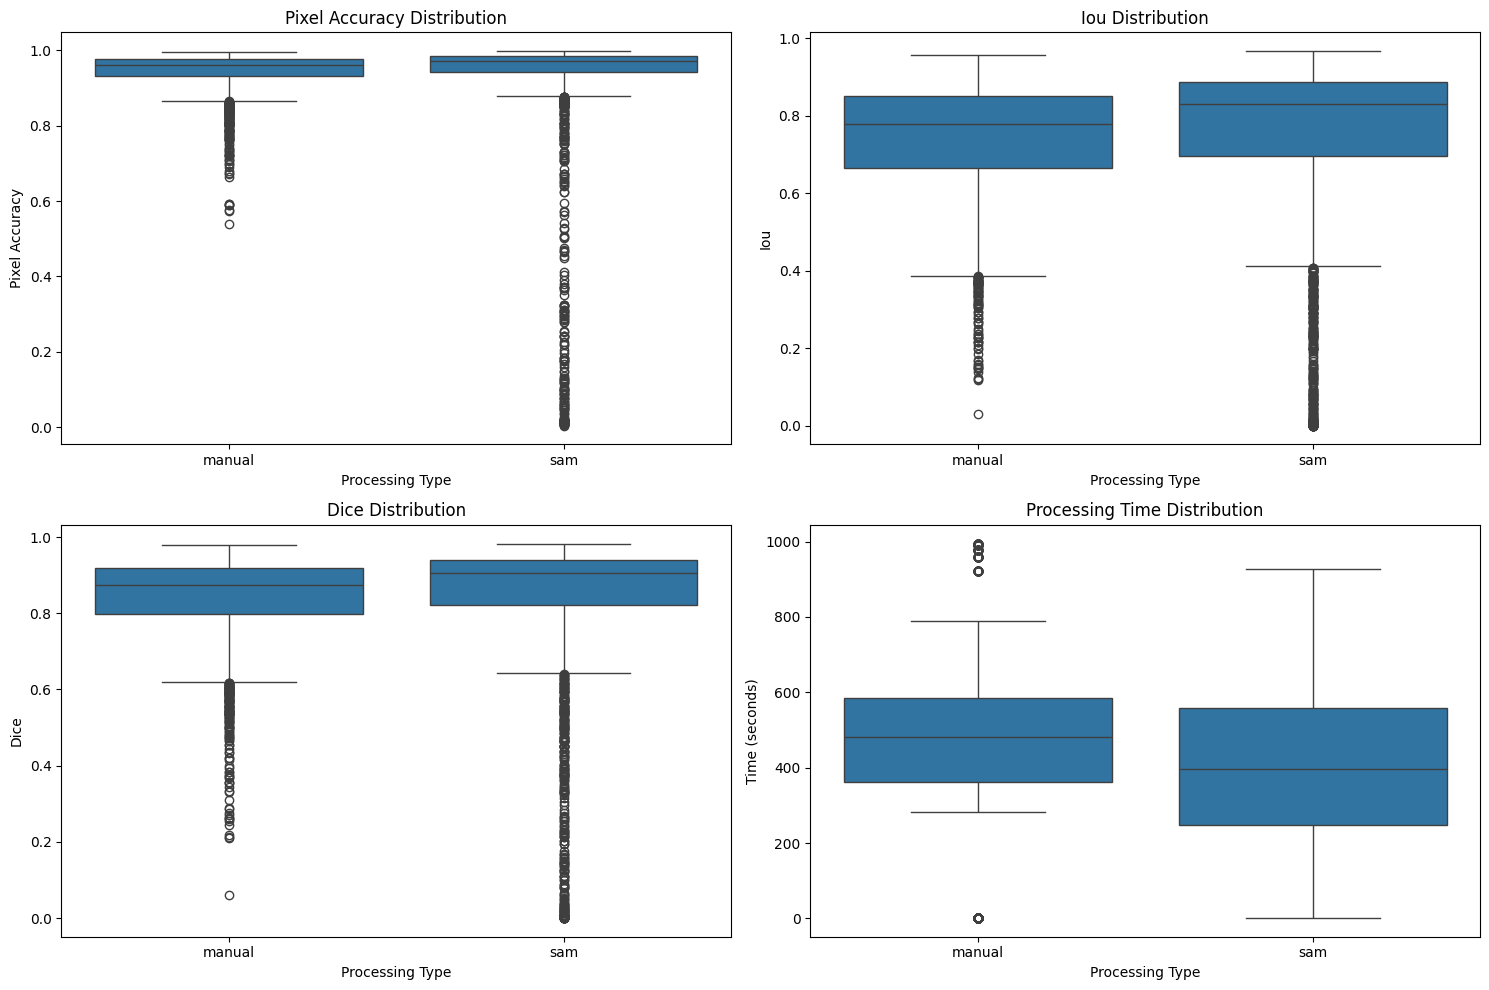

In [14]:

# Create visualizations
visualize_overall_metrics(df)

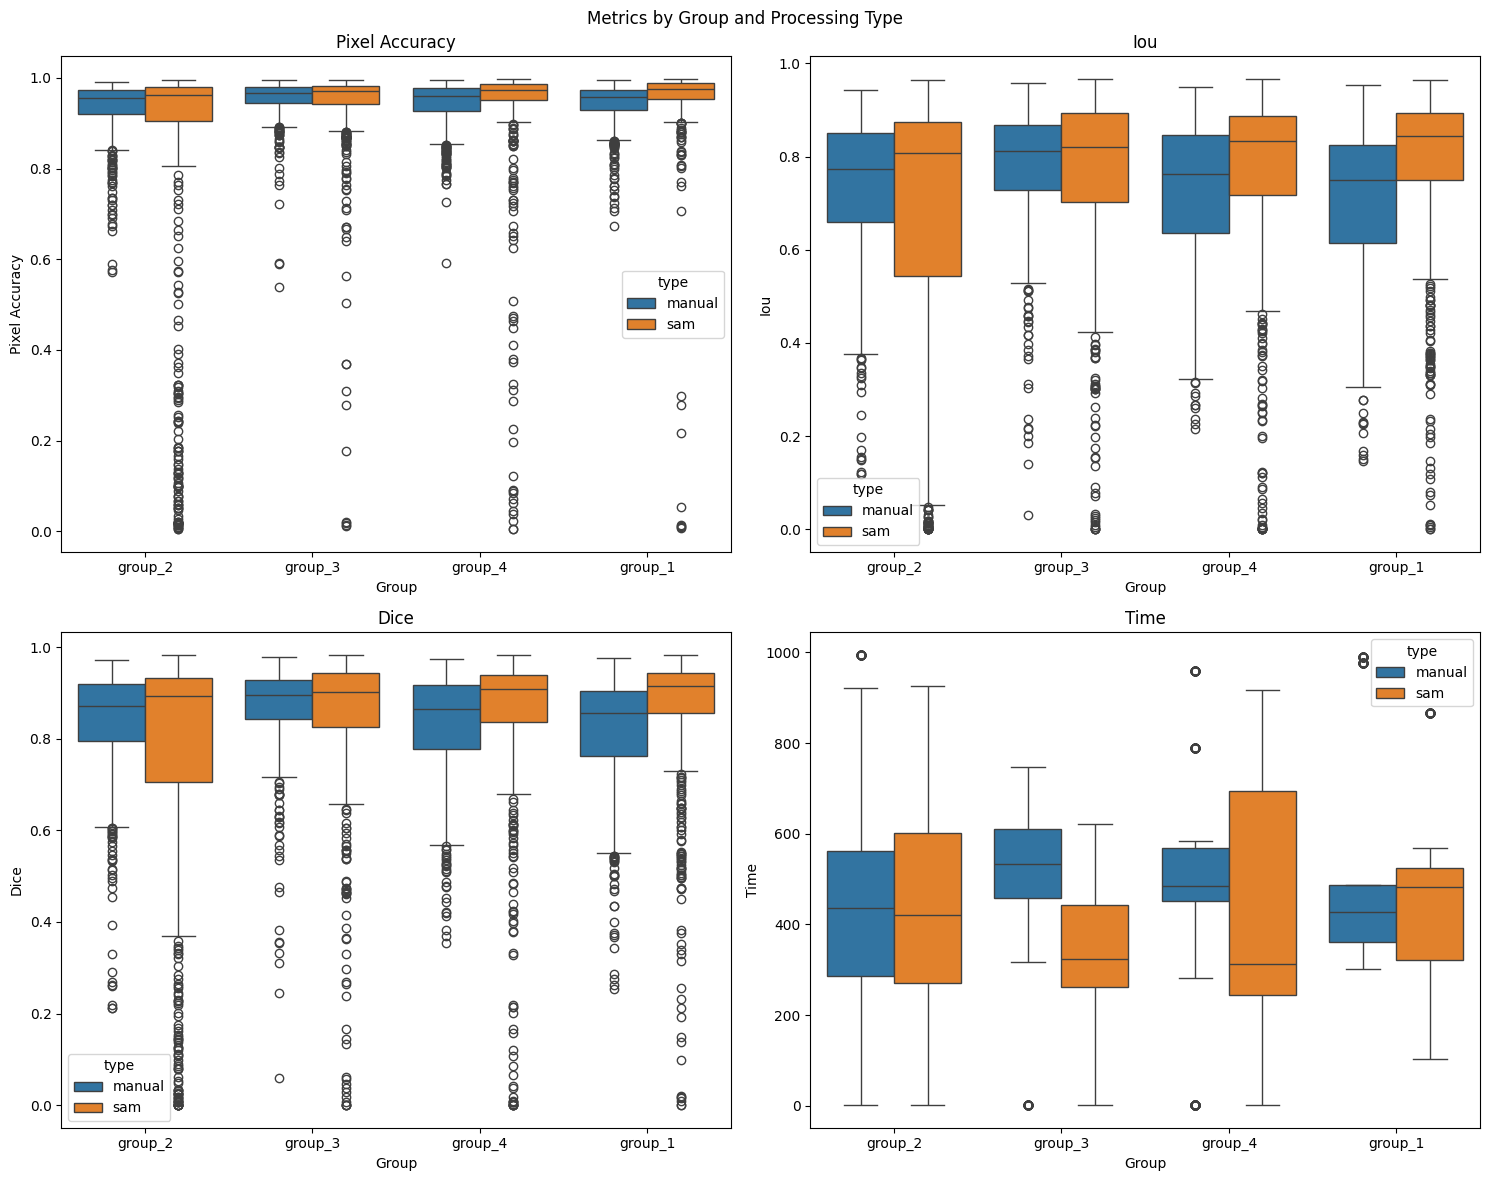

In [15]:
visualize_group_metrics(df)


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Set

def get_common_images(sessoes_folder: str) -> Set[str]:
    """Get list of images that are common across all groups."""
    image_sets = []
    for sessao in os.listdir(sessoes_folder):
        image_folder = os.path.join(sessoes_folder, sessao, "masked")
        images = os.listdir(image_folder)
        image_sets.append(set(images))
    
    common_images = set.intersection(*image_sets)
    print(f"Found {len(common_images)} common images across all groups")
    return common_images

def collect_common_metrics(sessoes_folder: str, original_mask_folder: str, common_images: Set[str]) -> pd.DataFrame:
    """Collect metrics for common images across all groups."""
    data_rows = []
    
    # Process each session
    for sessao in os.listdir(sessoes_folder):
        # Get group name and processing type
        group_name = next((g for g in ["group_1", "group_2", "group_3", "group_4"] if g in sessao), None)
        if not group_name:
            continue
            
        proc_type = "sam" if "sam" in sessao else "manual"
        
        # Process common images
        for image in common_images:
            mask_path = os.path.join(sessoes_folder, sessao, "masked", image)
            original_mask_name = image.replace('.jpg', '_segmentation.png')
            original_mask_path = os.path.join(original_mask_folder, original_mask_name)
            
            if not os.path.exists(original_mask_path) or not os.path.exists(mask_path):
                continue
                
            # Load and process images
            mask = cv2.imread(mask_path)
            original_mask_img = cv2.imread(original_mask_path)
            
            # Resize if necessary
            if original_mask_img.shape[:2] != mask.shape[:2]:
                target_shape = (
                    min(original_mask_img.shape[1], mask.shape[1]),
                    min(original_mask_img.shape[0], mask.shape[0])
                )
                original_mask_img = cv2.resize(original_mask_img, target_shape[::-1])
                mask = cv2.resize(mask, target_shape[::-1])
            
            # Get masks and calculate metrics
            mask_processed = get_segmentation_mask_from_image(mask, original_mask_img.shape)
            original_mask = get_segmentation_mask_from_image(original_mask_img, original_mask_img.shape)
            pixel_acc, iou, dice = calculate_metrics([mask_processed], [original_mask])
            
            # Get processing time
            with open(os.path.join(sessoes_folder, sessao, "time.txt"), "r") as f:
                time = float(f.readlines()[0])
            
            # Store data
            data_rows.append({
                "image": image,
                "group": group_name,
                "type": proc_type,
                "pixel_accuracy": pixel_acc,
                "iou": iou,
                "dice": dice,
                "time": time
            })
    
    return pd.DataFrame(data_rows)

def visualize_common_metrics(df: pd.DataFrame):
    """Create visualizations for metrics of common images."""
    # Overall comparison
    plt.figure(figsize=(15, 10))
    metrics = ['pixel_accuracy', 'iou', 'dice', 'time']
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(data=df, x='type', y=metric)
        plt.title(f'{metric.replace("_", " ").title()} - Common Images')
        plt.xlabel('Processing Type')
        plt.ylabel(metric.replace("_", " ").title())
    
    plt.tight_layout()
    plt.show()
    
    # Group-specific comparison
    plt.figure(figsize=(15, 12))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(data=df, x='group', y=metric, hue='type')
        plt.title(f'{metric.replace("_", " ").title()} by Group - Common Images')
        plt.xlabel('Group')
        plt.ylabel(metric.replace("_", " ").title())
    
    plt.tight_layout()
    plt.show()
    
    # Image-specific analysis
    plt.figure(figsize=(15, 6))
    avg_metrics = df.groupby('image')[['pixel_accuracy', 'iou', 'dice']].mean()
    sns.heatmap(avg_metrics.T, cmap='YlOrRd', center=0.5)
    plt.title('Average Metrics per Image')
    plt.show()



In [7]:

# Set paths
sessoes_folder = "./sessoes"
original_mask_folder = 'pad_segmentation_all/all-mask'

# Get common images
common_images = get_common_images(sessoes_folder)

# Collect metrics for common images
df = collect_common_metrics(sessoes_folder, original_mask_folder, common_images)

# Calculate and display summary statistics
overall_stats = df.groupby('type')[['pixel_accuracy', 'iou', 'dice', 'time']].agg(['mean', 'std', 'count'])
group_stats = df.groupby(['type', 'group'])[['pixel_accuracy', 'iou', 'dice', 'time']].agg(['mean', 'std'])


Found 25 common images across all groups


In [8]:

print("\nOverall Statistics for Common Images:")
display(overall_stats)



Overall Statistics for Common Images:


pixel_accuracy                       iou                      dice  \
                 mean       std count      mean       std count      mean   
type                                                                        
manual       0.947617  0.045419  1250  0.753830  0.143847  1250  0.850952   
sam          0.914885  0.190079  1250  0.746352  0.230084  1250  0.826890   

                              time                    
             std count        mean         std count  
type                                                  
manual  0.106849  1250  480.843060  241.636970  1250  
sam     0.215138  1250  405.626657  232.786869  1250

In [9]:
print("\nGroup Statistics for Common Images:")
display(group_stats)



Group Statistics for Common Images:


pixel_accuracy                 iou                dice  \
                         mean       std      mean       std      mean   
type   group                                                            
manual group_1       0.937957  0.050003  0.722362  0.156752  0.827884   
       group_2       0.945846  0.048915  0.752028  0.143517  0.849972   
       group_3       0.961580  0.029095  0.790642  0.121922  0.877057   
       group_4       0.942388  0.048968  0.742476  0.146732  0.843263   
sam    group_1       0.945942  0.120077  0.769443  0.199073  0.849936   
       group_2       0.831864  0.299137  0.678832  0.297463  0.758101   
       group_3       0.942789  0.120787  0.767988  0.196788  0.849594   
       group_4       0.935191  0.142607  0.765839  0.204035  0.846438   

                                time              
                     std        mean         std  
type   group                                      
manual group_1  0.121476  504.460182  232.729512  
       group_2  0.104602  449.367549  291.407353  
       group_3  0.089877  499.354180  177.042705  
       group_4  0.107169  469.978607  255.482654  
sam    group_1  0.179750  428.067545  205.231083  
       group_2  0.289651  432.748965  243.642707  
       group_3  0.176268  340.951425  166.866296  
       group_4  0.185568  431.252484  286.737109

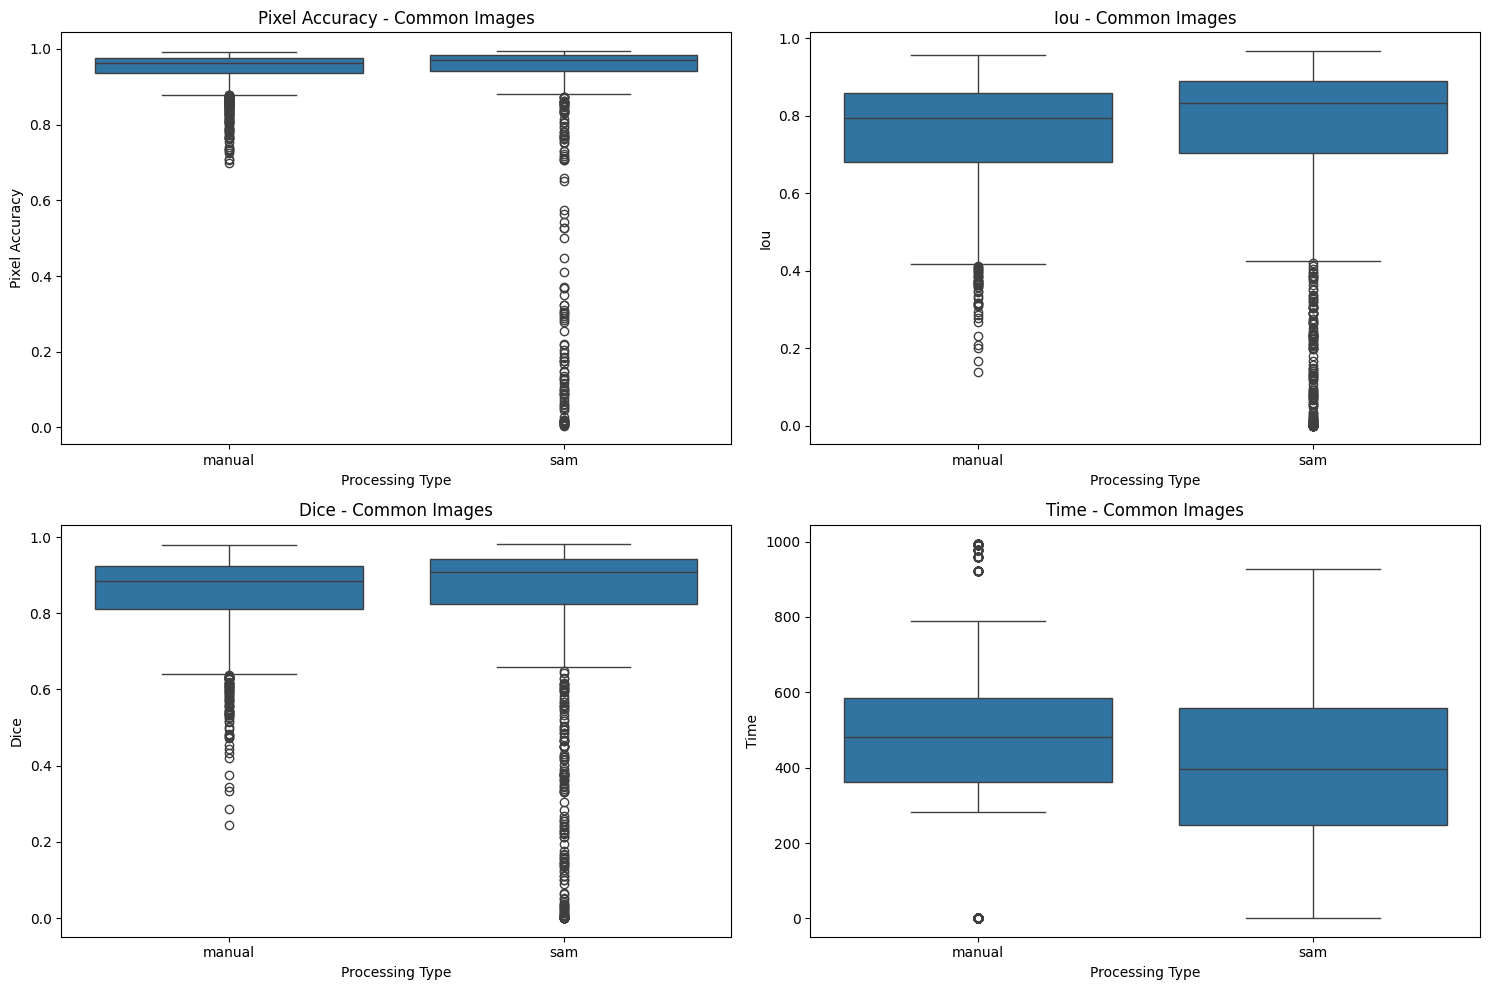

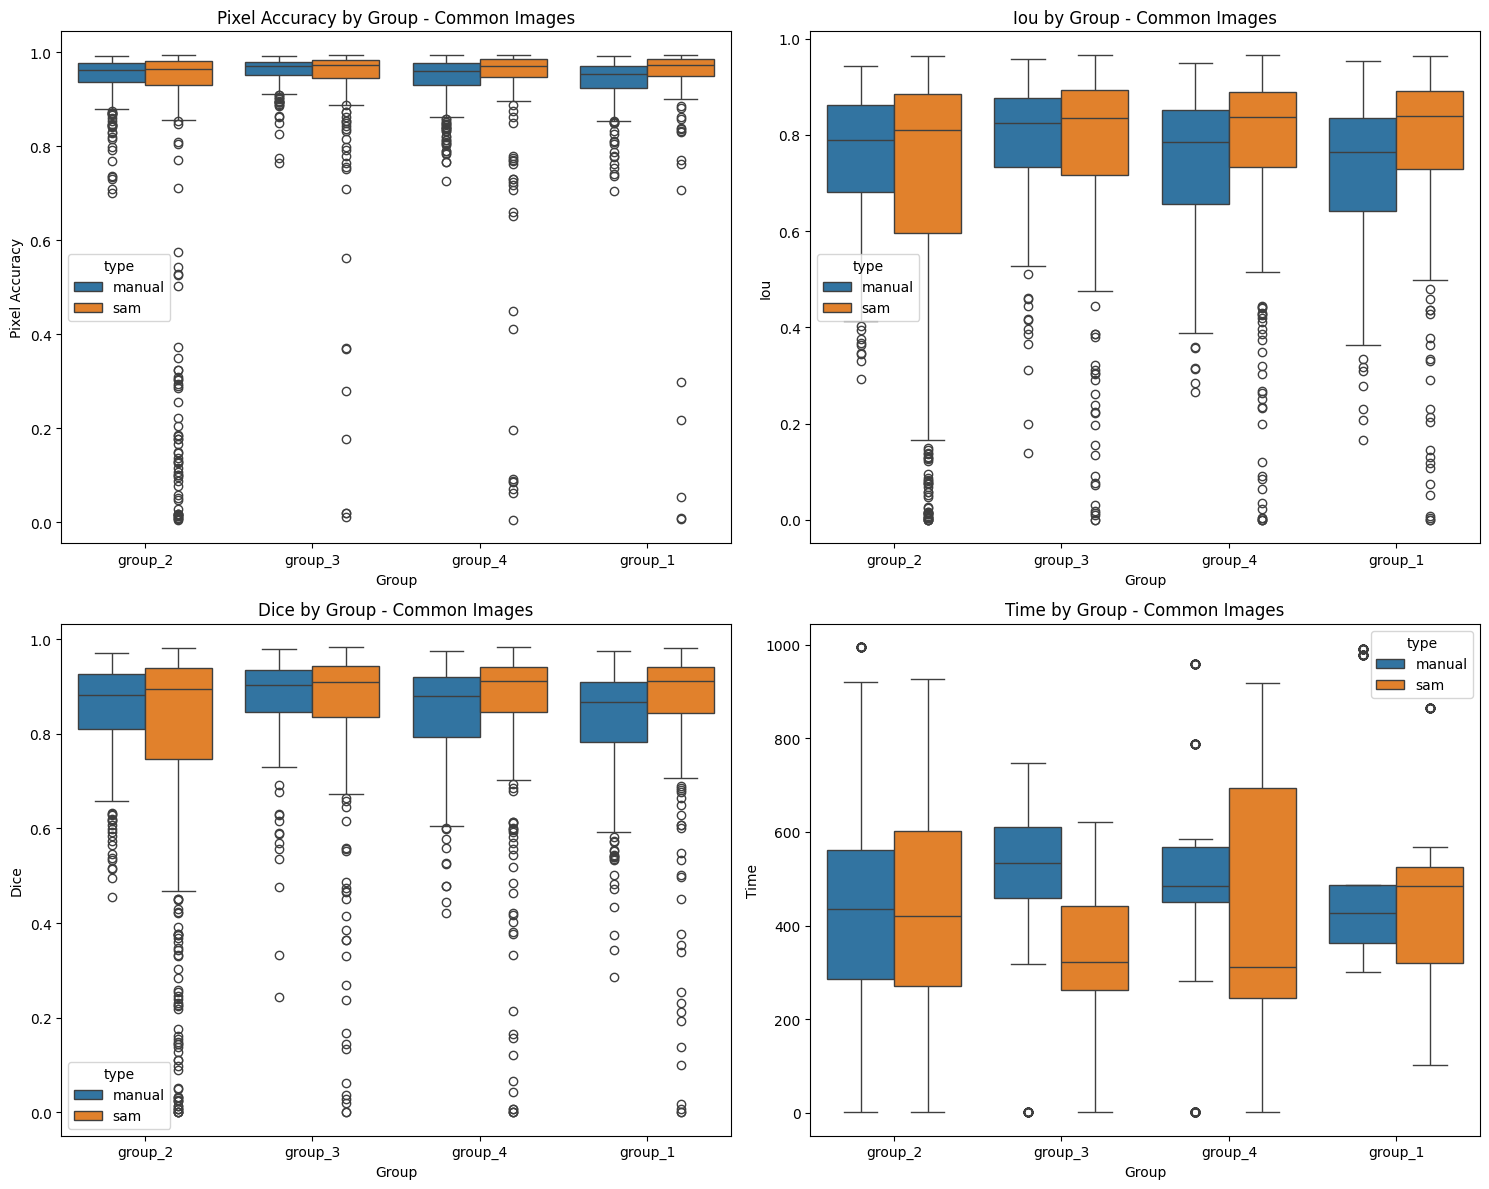

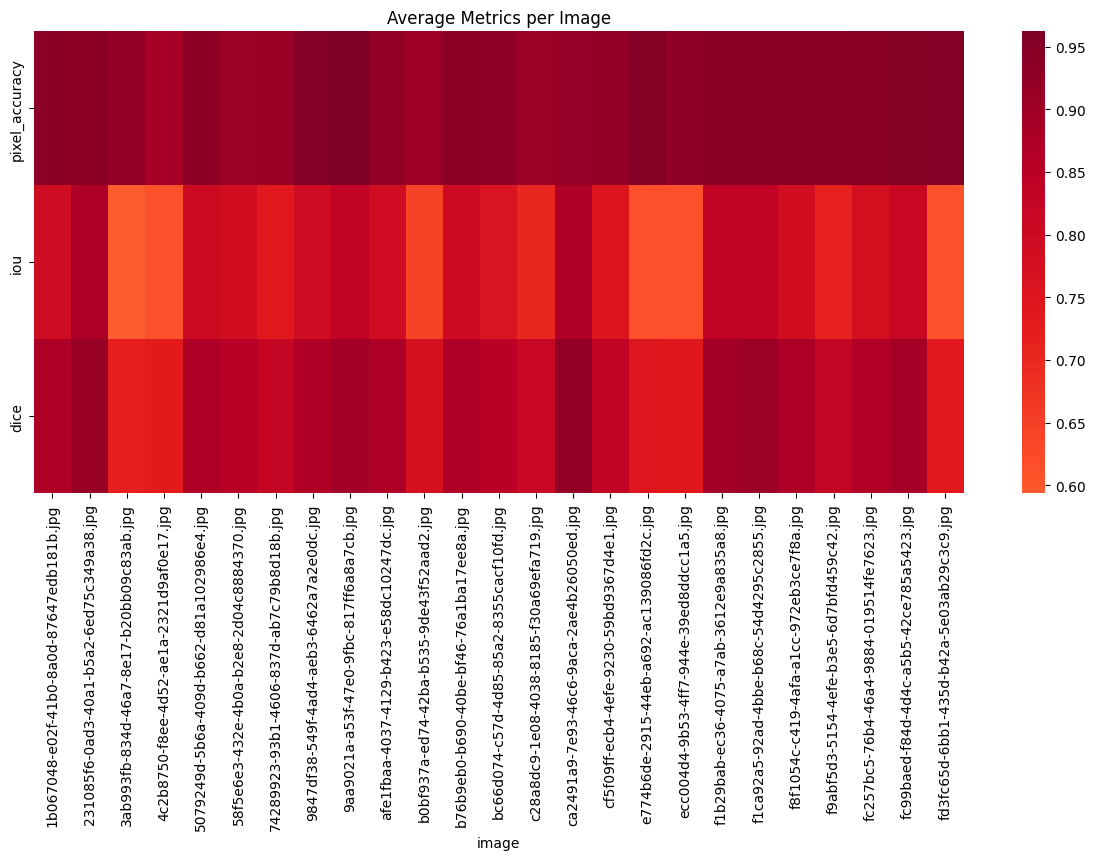

In [10]:

# Create visualizations
visualize_common_metrics(df)


In [11]:

# Perform statistical tests
from scipy import stats

# Comparing SAM vs Manual for each metric
statistical_tests = {}
for metric in ['pixel_accuracy', 'iou', 'dice', 'time']:
    sam_data = df[df['type'] == 'sam'][metric]
    manual_data = df[df['type'] == 'manual'][metric]
    t_stat, p_value = stats.ttest_ind(sam_data, manual_data)
    statistical_tests[metric] = {
        't_statistic': f"{t_stat:.4f}",
        'p_value': f"{p_value:.4e}"
    }

print("\nStatistical Tests (SAM vs Manual):")
display(pd.DataFrame(statistical_tests).T)



Statistical Tests (SAM vs Manual):


,t_statistic,p_value
pixel_accuracy,-5.9215,3.6286e-09
iou,-0.9743,3.3000e-01
dice,-3.5416,4.0503e-04
time,-7.9258,3.3855e-15
